In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_loc = "D:/Beam Characterization/2019_2_20/"
fname = "scanning_2019_2_20.h5"

In [3]:
fast_daq = {}
with h5py.File(data_loc+fname, 'r') as f:
    group = list(f.values())[0]
    readout = list(group.values())[0]
    wavemeter = list(readout.values())[1].value
    for dset in readout['PXIe-5171'].items():
        fast_daq[dset[0]] = dset[1].value

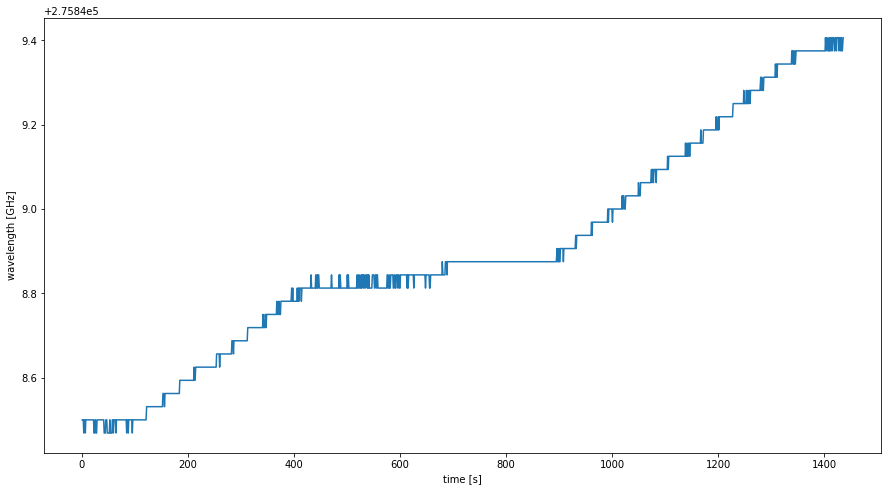

In [4]:
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(wavemeter[:,0], wavemeter[:,1]);
ax.set_xlabel('time [s]')
ax.set_ylabel('wavelength [GHz]');

# Correlation between photodiodes
Correlation between ch1 (absorption) and ch4 (UV power monitoring)

[5.96242594e-01 1.79023670e+03 8.98701872e-01 0.00000000e+00
 7.39837339e-03]


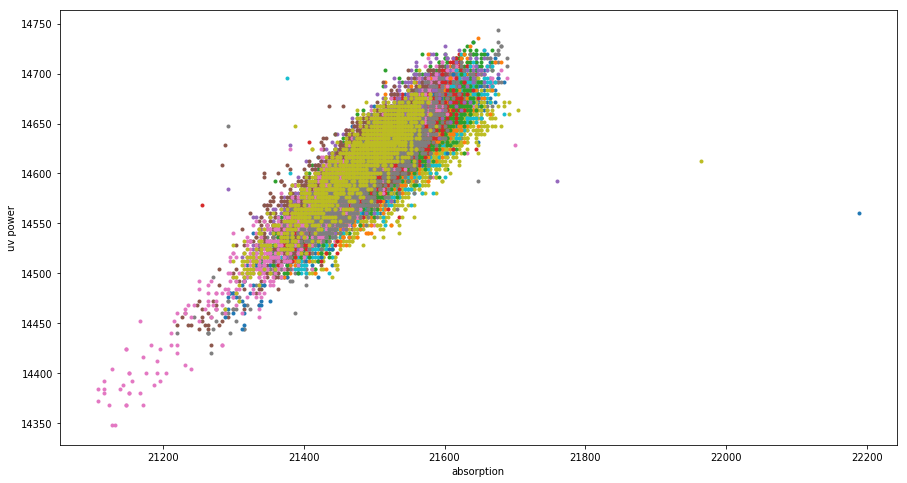

In [63]:
from scipy.stats.stats import pearsonr   
from scipy.stats import linregress

corr_abs_mon = []
fig, ax = plt.subplots(figsize = (15,8))
ax.set_xlabel("absorption")
ax.set_ylabel("uv power")
for i in range(1,20):
    corr_abs_mon.append(linregress(fast_daq['PXIe5171_{0}'.format(i)][:,1],fast_daq['PXIe5171_{0}'.format(i)][:,4]))
    ax.plot(fast_daq['PXIe5171_{0}'.format(i)][:,1],fast_daq['PXIe5171_{0}'.format(i)][:,4], '.')
print(np.mean(corr_abs_mon, axis = 0))

Correlation between ch2 (PMT) and ch4 (UV power monitoring)

[-5.48988268e-01  1.40139767e+04 -1.50137709e-01  7.88848894e-03
  8.94927112e-02]


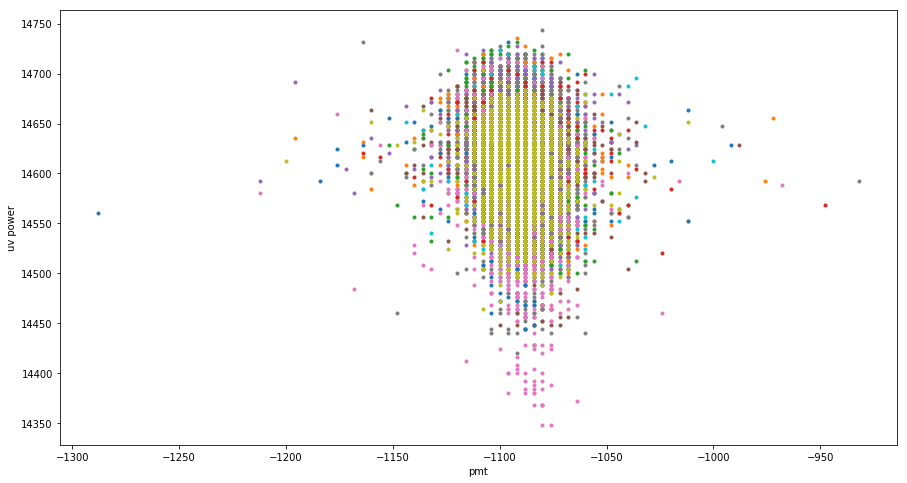

In [6]:
corr_pmt_mon = []
from scipy.stats.stats import pearsonr   
fig, ax = plt.subplots(figsize = (15,8))
ax.set_xlabel("pmt")
ax.set_ylabel("uv power")
for i in range(1,20):
    corr_pmt_mon.append(linregress(fast_daq['PXIe5171_{0}'.format(i)][:,2],fast_daq['PXIe5171_{0}'.format(i)][:,4]))
    ax.plot(fast_daq['PXIe5171_{0}'.format(i)][:,2],fast_daq['PXIe5171_{0}'.format(i)][:,4], '.')
print(np.mean(corr_pmt_mon, axis = 0))

In [7]:
def gaus(x,a,x0,sigma, offset):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+offset

6.267665304104254e-05
[-5.02086870e-02  3.12156987e+02  6.43260485e+01  1.45420273e+00]


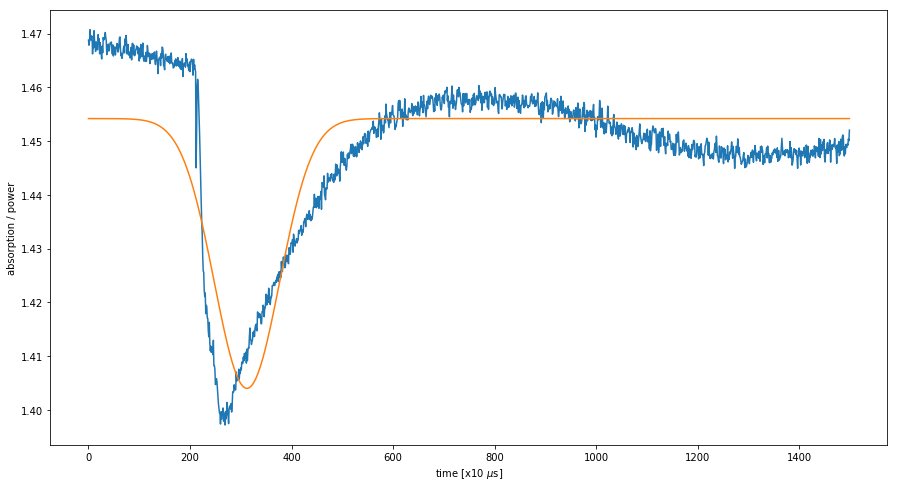

In [8]:
from scipy.optimize import curve_fit

idx = 32159
fig, ax = plt.subplots(figsize = (15,8))
data = fast_daq['PXIe5171_{0}'.format(idx)][:,1]/fast_daq['PXIe5171_{0}'.format(idx)][:,4]
x = np.arange(0,len(data),1)
p0 = (-0.05, 300, 64, 1.4)
bounds = ([-1, 220, 30, 1], [-0.02, 350, 80, 2])
popt, pcov = curve_fit(gaus, x, data, p0, bounds = bounds)
ax.plot(data)
ax.plot(x, gaus(x, *popt))
ax.set_xlabel('time [x10 $\mu$s]')
ax.set_ylabel('absorption / power')
print(np.sum((data - gaus(x, *popt))**2)/(len(x)-len(popt)))
print(popt)

In [9]:
from tqdm import tqdm
chi2 = []
fit = []
start, stop = 150, 600
idx_start, idx_stop = 1, len(fast_daq)
x = np.arange(start,stop,1)
p0 = (-0.05, 300, 64, 1.4)
bounds = ([-1, 220, 30, 1], [-0.02, 350, 80, 2])
for i in tqdm(range(idx_start, idx_stop)):
    data = fast_daq['PXIe5171_{0}'.format(i)][:,1]/fast_daq['PXIe5171_{0}'.format(i)][:,4]
    data = data[start:stop]
    m = np.argmin(data)
    if (m < 20) or (m > len(data)-10):
        continue
    if data[0] < data[280-start]:
        continue
    try:
        popt, pcov = curve_fit(gaus, x, data, p0, bounds = bounds)
        if (popt[0] > -0.0200002) or (popt[2] > 72):
            raise ValueError
        chi2.append((i,np.sum((data - gaus(x, *popt))**2)/(len(x)-len(popt))))
        fit.append((i,popt[0], popt[1], popt[2]))
    except Exception as e:
        continue

100%|████████████████████████████████████████████████████████████████████████████| 32374/32374 [20:24<00:00, 26.44it/s]


In [10]:
chi2_arr = np.array(chi2)
fit_arr = np.array(fit)

0.0004862469908388986
[-1.14717243e-01  3.20261734e+02  7.01732609e+01  1.40426163e+00]


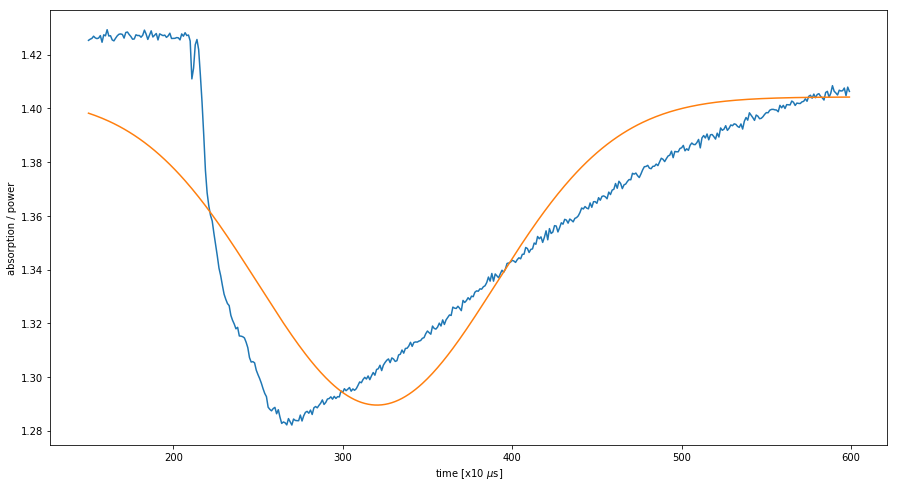

In [11]:
idx = -2
idx = int(fit_arr[idx][0])
fig, ax = plt.subplots(figsize = (15,8))
data = fast_daq['PXIe5171_{0}'.format(idx)][:,1]/fast_daq['PXIe5171_{0}'.format(idx)][:,4]
data = data[start:stop]
x = np.arange(start,stop,1)
p0 = (-0.05, 300, 64, 1.4)
bounds = ([-1, 220, 30, 1], [-0.02, 350, 80, 2])
popt, pcov = curve_fit(gaus, x, data, p0, bounds = bounds)
ax.plot(x, data)
ax.plot(x, gaus(x, *popt))
ax.set_xlabel('time [x10 $\mu$s]')
ax.set_ylabel('absorption / power')
print(np.sum((data - gaus(x, *popt))**2)/(len(x)-len(popt)))
print(popt)

In [12]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

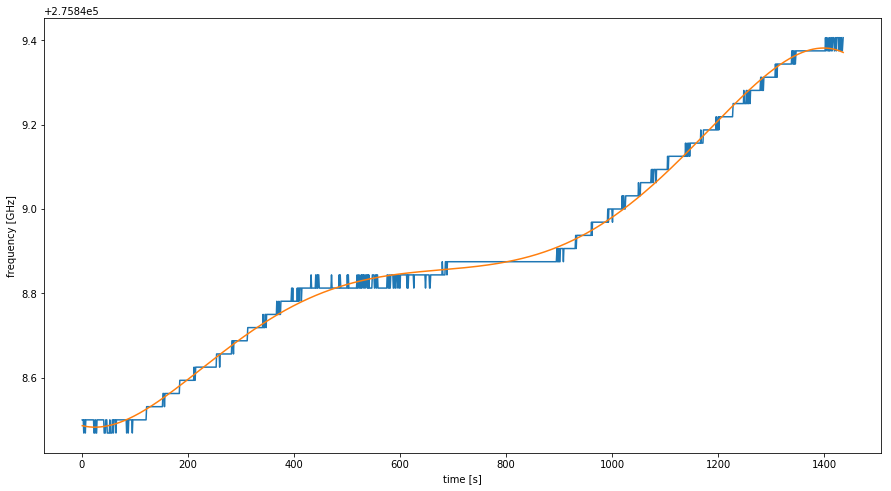

In [13]:
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d, splrep, splev

x, y = wavemeter[:,0], wavemeter[:,1]

tck = splrep(x, y, k=5, s=2)

fig, ax = plt.subplots(figsize = (15,8))
ax.plot(x,y);
ax.plot(x, splev(x, tck, der = 0))
ax.set_xlabel('time [s]')
ax.set_ylabel('frequency [GHz]');

In [14]:
attrs = dict()
for idx_good in fit_arr[:,0]:
    with h5py.File(data_loc+fname, 'r') as f:
        group = list(f.values())[0]
        readout = list(group.values())[0]
        dset = readout['PXIe-5171']['PXIe5171_{0}'.format(int(idx_good))]
        attrs[dset.name.split('/')[-1]] = dict(dset.attrs)

In [15]:
with h5py.File(data_loc+fname, 'r') as f:
    group = list(f.values())[0]
    tstart = dict(group.attrs)['time_offset']
    print(tstart)

1550695652.4616084


In [16]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Nearest neightbour

In [72]:
wavelength_values = []
for idx_good in fit_arr[:,0]:
    wavelength_values.append((int(idx_good), wavemeter[:,1][find_nearest_idx(wavemeter[:,0], idx_good*1/25)]))
wavelength_values = np.array(wavelength_values)

In [73]:
wavelength_peakheight = []
for idx, idx_good in enumerate(fit_arr[:,0]):
    idx_good = int(idx_good)
    data = fast_daq['PXIe5171_{0}'.format(idx_good)][:,1]/fast_daq['PXIe5171_{0}'.format(idx_good)][:,4]
    data = data[220:700]
    wavelength_peakheight.append((idx_good, wavelength_values[:,1][idx], data.ptp()))
wavelength_peakheight = np.array(wavelength_peakheight)

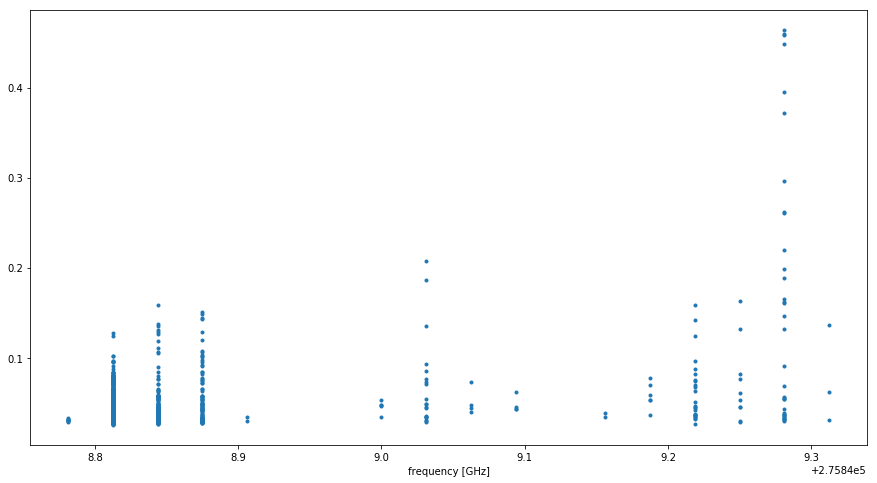

In [74]:
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(wavelength_peakheight[:,1], wavelength_peakheight[:,2], '.')
ax.set_xlabel('frequency [GHz]');

In [75]:
wavelength_data_groupave = []
wavelength_peakheight_grouped = []
for unique in np.unique(wavelength_peakheight[:,1]):
    ind = np.where(wavelength_peakheight[:,1] == unique)[0]
    wavelength_peakheight_grouped.append((unique, np.mean(wavelength_peakheight[:,2][ind]), np.std(wavelength_peakheight[:,2][ind])))
    tmp = []
    for index in wavelength_peakheight[:,0][ind]:
        index = int(index)
        tmp.append(fast_daq['PXIe5171_{0}'.format(index)][:,1]/fast_daq['PXIe5171_{0}'.format(index)][:,4])
    wavelength_data_groupave.append(((ind), unique, np.mean(np.array(tmp), axis = 0)))
wavelength_peakheight_grouped = np.array(wavelength_peakheight_grouped)

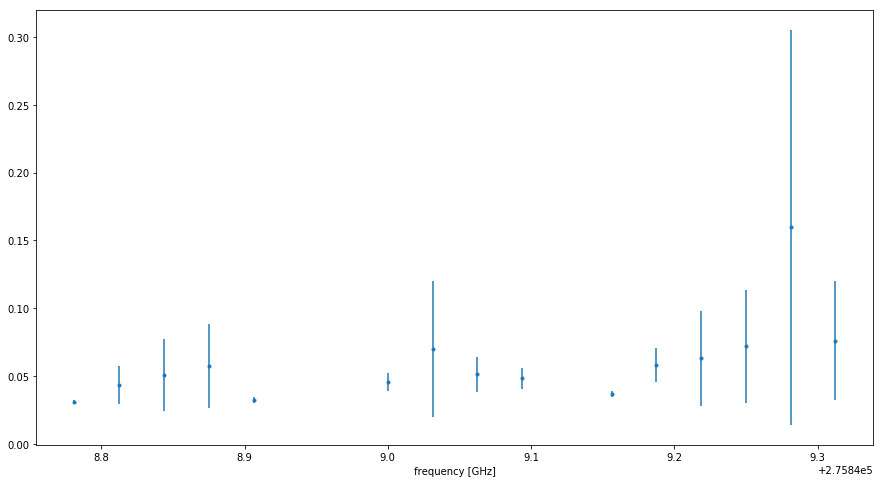

In [76]:
fig, ax = plt.subplots(figsize = (15,8))
ax.errorbar(wavelength_peakheight_grouped[:,0], wavelength_peakheight_grouped[:,1], yerr = wavelength_peakheight_grouped[:,2], fmt = '.')
ax.set_xlabel('frequency [GHz]');

In [77]:
wavelength_peakheight_grouped = []
for dat in wavelength_data_groupave:
    wavelength_peakheight_grouped.append((dat[1], np.mean(dat[2][:100])-np.min(dat[2][230:500])))
wavelength_peakheight_grouped = np.array(wavelength_peakheight_grouped)

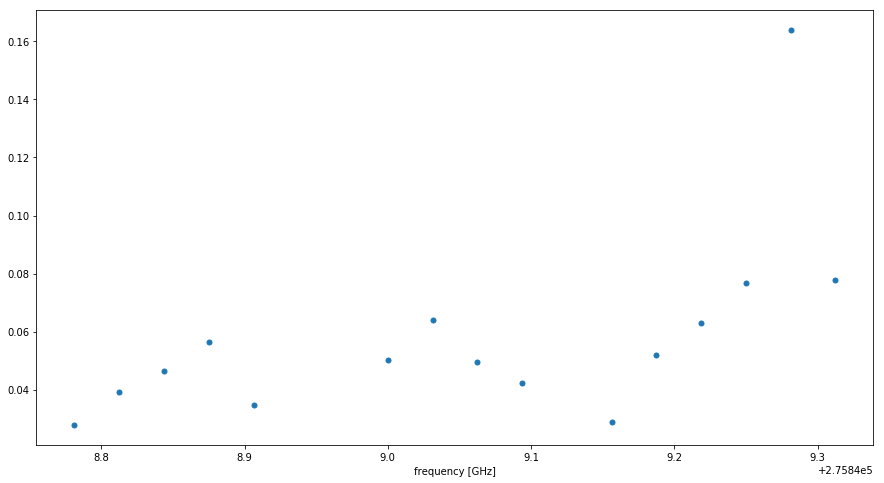

In [78]:
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(wavelength_peakheight_grouped[:,0], wavelength_peakheight_grouped[:,1], '.', ms = 10)
ax.set_xlabel('frequency [GHz]');

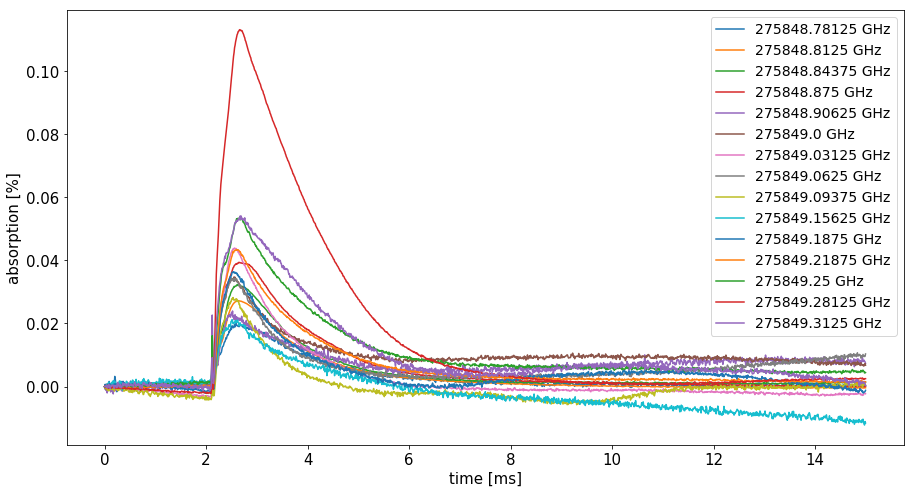

In [132]:
fig, ax = plt.subplots(figsize = (15,8))

for dat in wavelength_data_groupave:
    ax.plot(np.arange(0,len(dat[2]),1)*1e-2,1-dat[2]/dat[2][0], label = '{0} GHz'.format(dat[1]))
ax.legend(fontsize = 14)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('time [ms]', fontsize = 15)
ax.set_ylabel('absorption [%]', fontsize = 15);
fig.savefig('TlF_absorption_peaks.png')

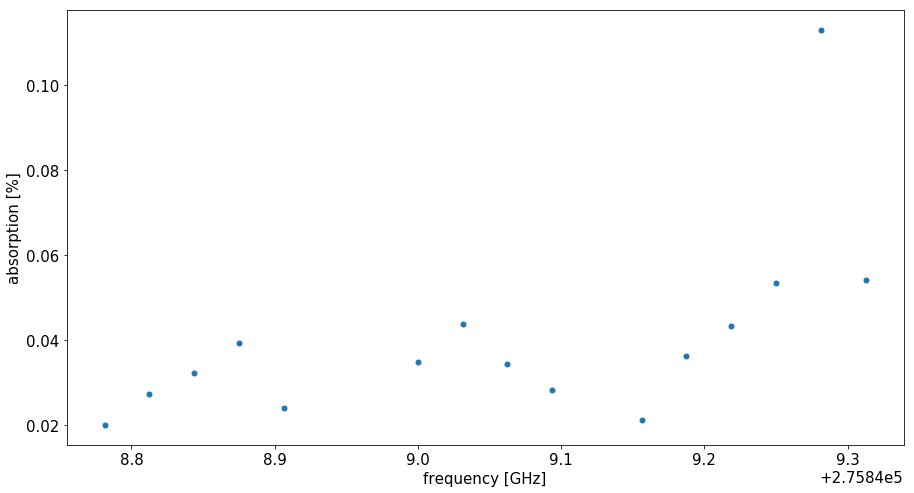

In [133]:
wl, absorption = [],[]
for dat in wavelength_data_groupave:
    wl.append(dat[1])
    absorption.append(np.max((1-dat[2]/dat[2][0])[220:600]))
    
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(wl, absorption, '.', ms = 10)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_xlabel('frequency [GHz]', fontsize = 15)
ax.set_ylabel('absorption [%]', fontsize = 15);
fig.savefig('TlF_scan.png')

275849.28125


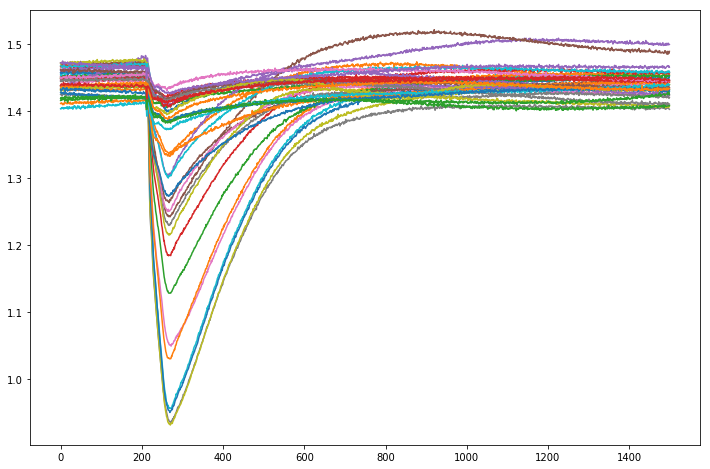

In [104]:
fig, ax = plt.subplots(figsize = (12,8))
idx = -2
print(wavelength_data_groupave[idx][1])
for index in wavelength_peakheight[:,0][wavelength_data_groupave[idx][0]]:
    index = int(index)
    ax.plot(fast_daq['PXIe5171_{0}'.format(index)][:,1]/fast_daq['PXIe5171_{0}'.format(index)][:,4])

275848.8125


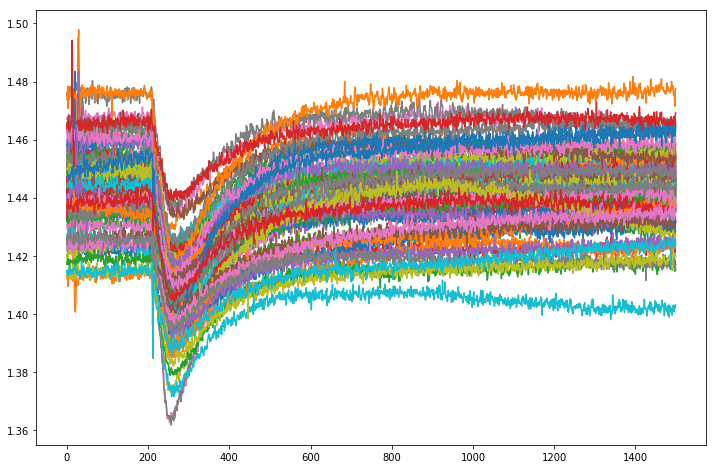

In [105]:
fig, ax = plt.subplots(figsize = (12,8))
idx = 1
print(wavelength_data_groupave[idx][1])
for index in wavelength_peakheight[:,0][wavelength_data_groupave[idx][0]][:100]:
    index = int(index)
    ax.plot(fast_daq['PXIe5171_{0}'.format(index)][:,1]/fast_daq['PXIe5171_{0}'.format(index)][:,4])

In [60]:
def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    dat = wavelength_data_groupave[i][2]
    x = np.arange(0,1500,1)
    line.set_data(x,dat)
    return (line,)

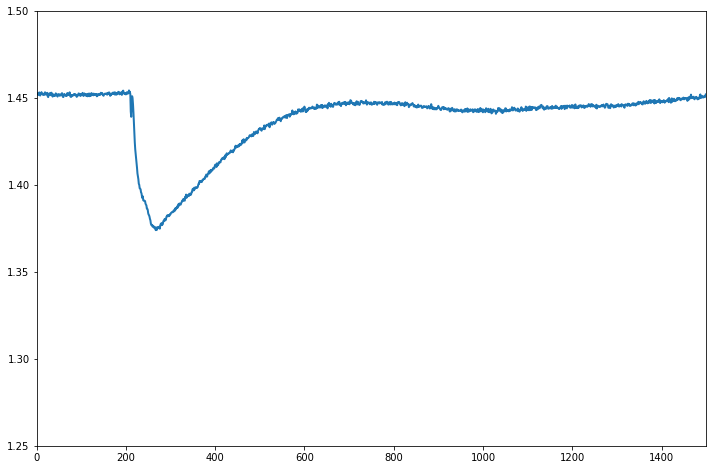

In [61]:
from matplotlib import animation, rc
from IPython.display import HTML

fig, ax = plt.subplots(figsize = (12,8))
line, = ax.plot([], [], lw=2)
ax.set_xlim(0,1500)
ax.set_ylim(1.25,1.5)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(wavelength_data_groupave), interval=1000, 
                               blit=True)
HTML(anim.to_html5_video())

# Interpolation

In [64]:
wavelength_values = []
for idx_good in fit_arr[:,0]:
    wavelength_values.append((int(idx_good), splev(idx_good*1/25, tck, der = 0)))
wavelength_values = np.array(wavelength_values)

In [65]:
wavelength_peakheight = []
for idx, idx_good in enumerate(fit_arr[:,0]):
    idx_good = int(idx_good)
    data = fast_daq['PXIe5171_{0}'.format(idx_good)][:,1]/fast_daq['PXIe5171_{0}'.format(idx_good)][:,4]
    data = data[220:600]
    wavelength_peakheight.append((wavelength_values[:,1][idx], data.ptp()))
wavelength_peakheight = np.array(wavelength_peakheight)

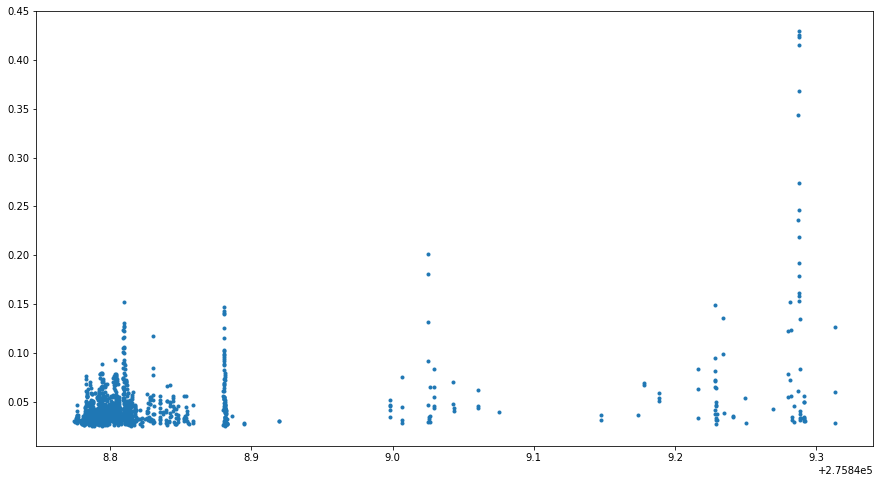

In [66]:
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(wavelength_peakheight[:,0], wavelength_peakheight[:,1], '.')

# Average by wavelength

In [67]:
wavelength_values = []
for idx in range(1,len(fast_daq)):
    wavelength_values.append((int(idx), wavemeter[:,1][find_nearest_idx(wavemeter[:,0], idx*1/25)]))
wavelength_values = np.array(wavelength_values)    

In [68]:
wavelength_data_groupave = []
for unique in np.unique(wavelength_values[:,1]):
    ind = np.where(wavelength_values[:,1] == unique)[0]
    tmp = []
    for idx in wavelength_values[:,0][ind]:
        idx = int(idx)
        tmp.append(fast_daq['PXIe5171_{0}'.format(idx)][:,1]/fast_daq['PXIe5171_{0}'.format(idx)][:,4])
    wavelength_data_groupave.append((ind, unique, np.mean(np.array(tmp), axis = 0)))

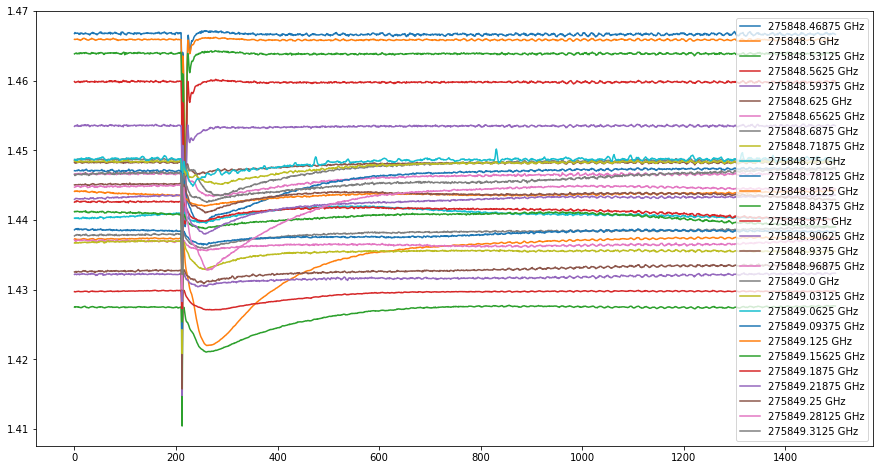

In [69]:
fig, ax = plt.subplots(figsize = (15,8))

for dat in wavelength_data_groupave:
    ax.plot(dat[2], label = '{0} GHz'.format(dat[1]))
ax.legend(loc = 4)

In [70]:
wavelength_peakheight_grouped = []
for dat in wavelength_data_groupave:
    wavelength_peakheight_grouped.append((dat[1], np.mean(dat[2][:100])-np.min(dat[2][230:500])))
wavelength_peakheight_grouped = np.array(wavelength_peakheight_grouped)

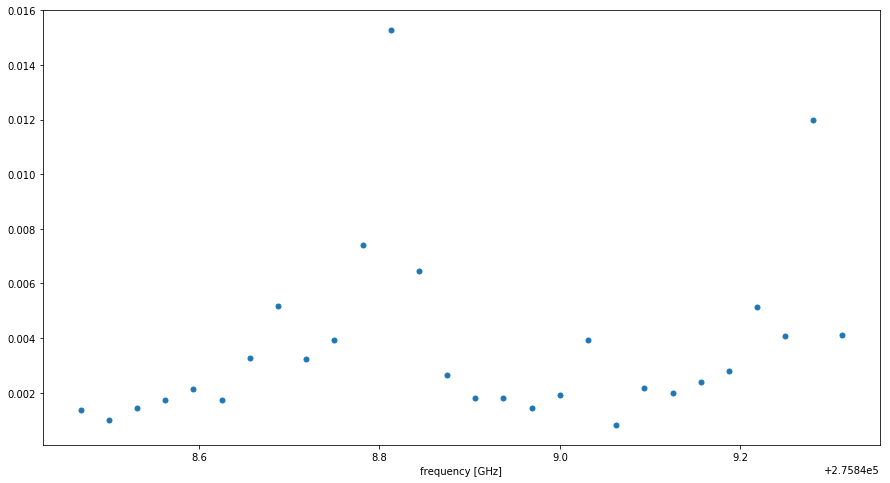

In [71]:
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(wavelength_peakheight_grouped[:,0], wavelength_peakheight_grouped[:,1], '.', ms = 10)
ax.set_xlabel('frequency [GHz]');